# DAQA Workshop

<style>
  a {
    color: #1ea5a6 !important;
  }
</style>

This is an exploratory data analysis of collected data from [DAQA](https://qldarch.net/) with a focus on people, education affliation and organisations. The work presented below form part of ACDE's presentation at [*Data Futures for Architectural History and Cultural Heritage*](https://www.eventbrite.com.au/e/data-futures-for-architectural-history-and-cultural-heritage-in-person-tickets-451462856557), a collaborative workshop held in November 2022 with DAQA and Curtin University Library. This analysis was followed up with a more detailled analysis which can found in the following page, [DAQA Analysis](https://acd-engine.github.io/jupyterbook/Analysis_DAQA.html).

First, we display the number of records for each entity as per the ACDEA.


In [53]:
# for data mgmt
import json
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import requests, gzip, io, os, json
import ast

# for plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.colors import to_rgba

# for hypothesis testing
from scipy.stats import chi2_contingency
from scipy.stats import pareto

import warnings
warnings.filterwarnings("ignore")

# provide folder_name which contains uncompressed data i.e., csv and jsonl files
# only need to change this if you have already downloaded data
# otherwise data will be fetched from google drive
global folder_name
folder_name = 'data/local'

def fetch_small_data_from_github(fname):
    url = f"https://raw.githubusercontent.com/acd-engine/jupyterbook/master/data/analysis/{fname}"
    response = requests.get(url)
    rawdata = response.content.decode('utf-8')
    return pd.read_csv(io.StringIO(rawdata))

def check_if_csv_exists_in_folder(filename):
    try: return pd.read_csv(os.path.join(folder_name, filename), low_memory=False)
    except: return None

def fetch_data(filetype='csv', acdedata='organization', source='googledrive'):
    filename = f'acde_{acdedata}_202305080816.{filetype}'

    # first check if the data exists in current directory
    data_from_path = check_if_csv_exists_in_folder(filename)
    if data_from_path is not None: return data_from_path

    download_url = None
    github_url = f"https://raw.githubusercontent.com/acd-engine/jupyterbook/master/data/{filename}.gz"

    if source == 'googledrive':
        urls = fetch_small_data_from_github('acde_data_gdrive_urls.csv')
        sharelink = urls[urls.data == acdedata][filetype].values[0]
        url = f'https://drive.google.com/u/0/uc?id={sharelink}&export=download&confirm=yes'

    elif source == 'github': url = github_url
    else: return None
    
    response = requests.get(url)

    try:
        sha = response.content.decode('utf-8').splitlines()[1].split('oid sha256:')[-1]
        size = response.content.decode('utf-8').splitlines()[2].split('size ')[-1]

        # Step 1: Create the JSON object
        json_data = {"operation": "download", "transfer": ["basic"], "objects": [{"oid": sha, "size": int(size)}]}

        # Step 2: Send a POST request to the LFS API
        url = "https://github.com/acd-engine/jupyterbook.git/info/lfs/objects/batch"
        headers = {"Accept": "application/vnd.git-lfs+json","Content-type": "application/json"}
        response = requests.post(url, headers=headers, data=json.dumps(json_data))
        response_json = response.json()

        # Step 3: Extract the download URL from the response
        download_url = response_json["objects"][0]["actions"]["download"]["href"]
    except:
        pass

    if download_url is not None: response = requests.get(download_url)

    decompressed_data = gzip.decompress(response.content)
    decompressed_buffer = io.StringIO(decompressed_data.decode('utf-8'))

    try:
        if filetype == 'csv': df = pd.read_csv(decompressed_buffer, low_memory=False)
        else: df = [json.loads(jl) for jl in pd.read_json(decompressed_buffer, lines=True, orient='records')[0]]
        return pd.DataFrame(df)
    except: return None 

def fetch_all_DAQA_data():
    daqa_data_dict = dict()
    for entity in ['event', 'organization', 'person', 'place', 'recognition', 'resource', 'work']:
        daqa_this_entity = fetch_data(acdedata=entity)
        daqa_data_dict[entity] = daqa_this_entity[daqa_this_entity.data_source.str.contains('DAQA')]
    return daqa_data_dict

df_daqa_dict = fetch_all_DAQA_data() # 1 min if data is already downloaded

In [54]:
# print number of records for each entity
print('Number of records for each entity in DAQA dataset')
print('_________________________________________________\n')
for k,v in df_daqa_dict.items(): print(k + ':',len(v))

Number of records for each entity in DAQA dataset
_________________________________________________

event: 0
organization: 967
person: 1103
place: 1939
recognition: 27
resource: 7696
work: 2203


## DAQA Persons

There are 1103 person records in DAQA. The following bar charts show the proportion of certain characteristics of persons in DAQA. We list the main findings below:
- When we consider `null` cases, we find that males make up almost two-thirds of the persons records.
- Without null cases, we see a male-to-female ratio of 85:15.
- Out of the 1103 persons, 912 are architects making up 83% of the total persons records.
- We check for any categorical associations between gender and whether a person is an architect. Using a chi-square test of association, we find statistically significant results with a p-value of 0.02. This suggests that these two variables are not independent of each other, and that more males tend to be architects than females. 
- Lastly, we find that 60% of the persons recorded in DAQA practiced in Queensland.

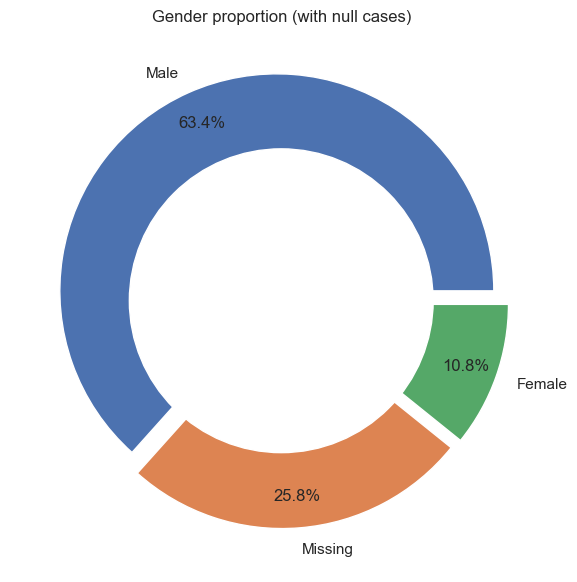

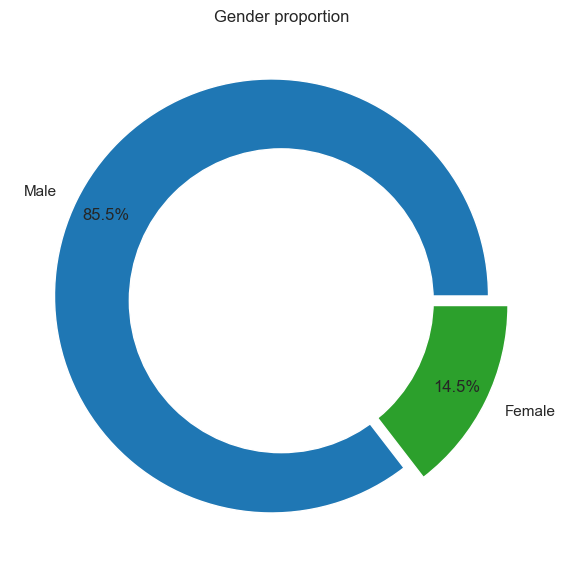

In [55]:
## Gender Proportion
df_gender=pd.DataFrame(dict(Counter(df_daqa_dict['person']["gender"])).items(),
                              columns=["Gender","Frequency"])

# explosion
explode = (0.05, 0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender['Frequency'], labels=['Male','Missing','Female'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion (with null cases)')
  
# Displaying Chart
plt.show()

# without null
# explosion
explode = (0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender[~df_gender['Gender'].isnull()]['Frequency'], labels=['Male','Female'],
        autopct='%1.1f%%', pctdistance=0.85, colors=['tab:blue','tab:green'],
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion')
  
# Displaying Chart
plt.show()

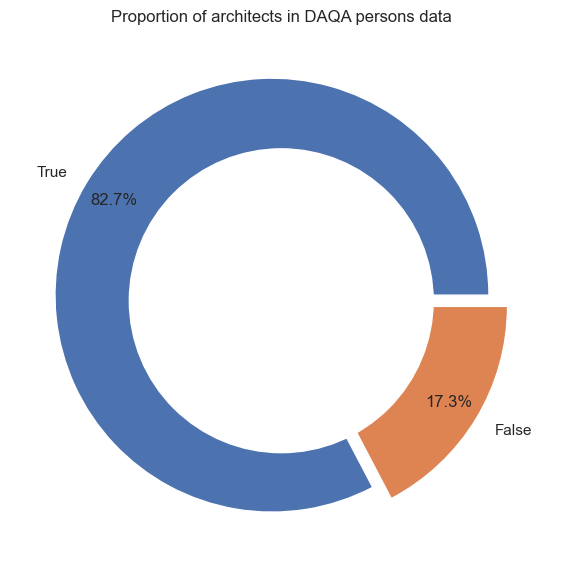

In [56]:
# Proportion of is_architect field 
df_isarch=pd.DataFrame(dict(Counter(df_daqa_dict['person']["is_architect"])).items(),
                              columns=["is_architect","Frequency"])

# explosion
explode = (0.05, 0.05)
  
# Pie Chart
plt.pie(df_isarch['Frequency'], labels=df_isarch['is_architect'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Proportion of architects in DAQA persons data')
  
# Displaying Chart
plt.show()

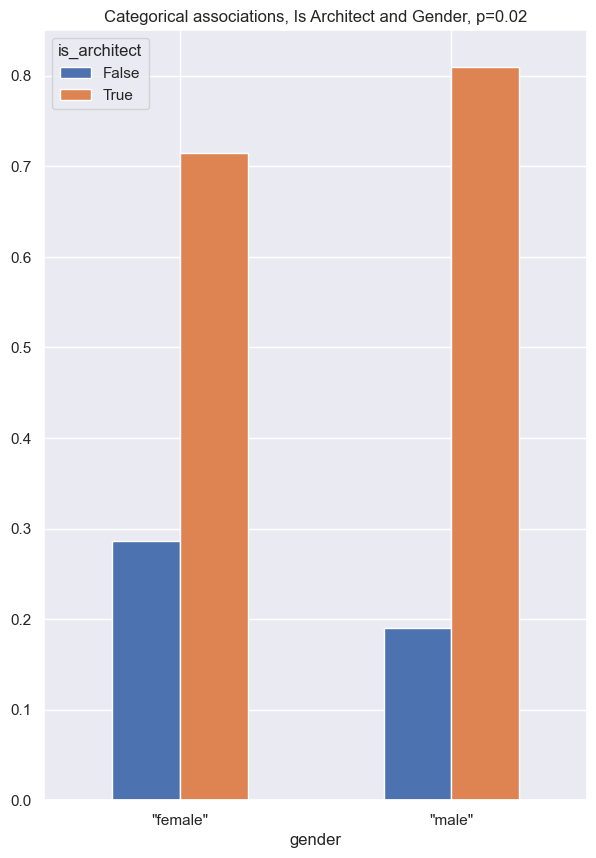

In [57]:
# categorical associations  - gender and is_architect
pd.crosstab(df_daqa_dict['person']['gender'], 
            df_daqa_dict['person']['is_architect'], normalize='index')\
.plot(kind='bar', rot=0)

plt.title(f'Categorical associations, Is Architect and Gender, p={str(round(chi2_contingency([[34, 85], [133, 566]])[1],2))}')
plt.show()

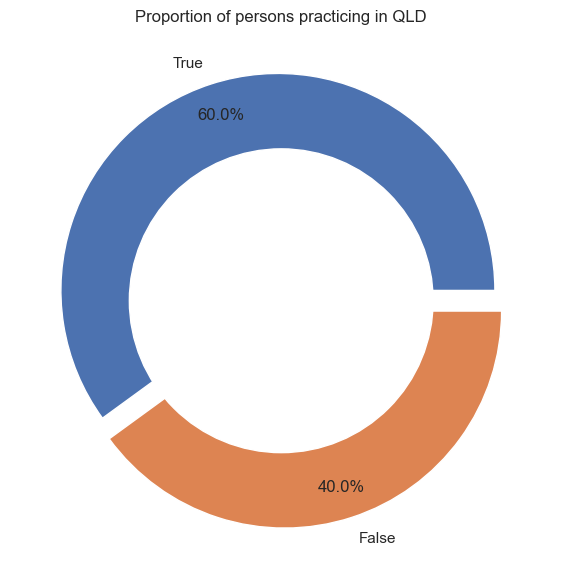

In [58]:
# Proportion of architects practicing in Queensland
df_isarchfromqld=pd.DataFrame(dict(Counter(df_daqa_dict['person']["is_practiceInQueensland"])).items(),
                              columns=["is_practiceInQueensland","Frequency"])
# explosion
explode = (0.05, 0.05)
  
# Pie Chart
plt.pie(df_isarchfromqld['Frequency'], 
        labels=df_isarchfromqld['is_practiceInQueensland'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Proportion of persons practicing in QLD')
  
# Displaying Chart
plt.show()

### Education experiences

Next we analyse the educational affliations of persons in DAQA. First we clean the data by removing rows with missing data and tidying inconsistent values, and assess the summary statistics of the data. 
- We find that out of the 1103 persons in DAQA, only 163 person records (15%) have populated education fields. As there are 210 education records, this suggests that most persons have one completed education record. However, there are some cases where a person has four education records i.e., `Robert Riddel`.
- There are 39 unique education institutions in the data, with the University of Queensland being the most common with 78 occurences.
- There are 10 unique education qualifications in the data, with Diploma of Architecture being the most common with 84 occurences.
- Over two-thirds of education records are associated with a Queensland education institution (163 records).

In [71]:
# inspect data
ee_df = pd.DataFrame()
for ii,ee in enumerate(df_daqa_dict['person']['education_trainings']):
    if isinstance(ee, float): continue
    if len(ee):
        this_ee = pd.json_normalize(json.loads(ee))
        this_ee['display_name'] = ast.literal_eval(df_daqa_dict['person'].iloc[ii]['display_name'])
        ee_df = ee_df.append(this_ee)

# remove incomplete and remove rows with no completion dates
ee_df = ee_df[ee_df['coverage_range.date_range.date_end.year'] != 'incomplete']
ee_df = ee_df[~ee_df['coverage_range.date_range.date_end.year'].isnull()]

# remove rows with no qualification data
ee_df = ee_df[~ee_df['organization.qualification'].isnull()]
ee_df = ee_df[ee_df['organization.qualification'] != 'INCOMPLETE']

# remove rows with no school name
ee_df = ee_df[~ee_df['organization.name'].isnull()]

# remove case of honorary doctorates
ee_df = ee_df[ee_df['organization.name'] != 'QUT, UQ']
     
# fix missing place name
ee_df.loc[ee_df['organization.name'] == 'CAMBRIDGE','coverage_range.place'] = 'UK'
    
# fix anomalies
anomalies = ee_df[ee_df.display_name.str.contains('Richard Allom|Lilly Addison|Edward James Archibald Weller|Robyn Hesse|Malcolm Bunzli|Dorothy Brennan|Donald Watson|Bruce Goodsir')]['display_name'].unique()
ee_df = ee_df[~ee_df.display_name.isin(anomalies)]

In [72]:
# clean qualification data
ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['BACHELOR OF ARCHITECTURE',
                                                'BA','B.ARCH','BArch hons']),
                                         'BArch',ee_df['organization.qualification'])

ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['BA SCIENCE(BOTANY)',
                                                'BA Town Planning','BA Larch',
                                                'BA Design Studies',
                                                'BA Design','BA Design',
                                                'BAppSci','BA (?) Town Planning']),
                                         'Bachelor (Other)',ee_df['organization.qualification'])

ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['Diploma','DIPLOMA',
                                                'DIP Arch','DIPLOMA OF ARCHITECTURE',
                                                'DipA']),
                                         'DipArch',ee_df['organization.qualification'])

ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['GradDip Uni Planning',
                                                'GradDip Project Management',
                                                'Grad Dip Town Planning',
                                                'Gdip Urban Planning',
                                                'GradDip landscape','Grad Dip Landscape']),
                                         'GDip (Other)',ee_df['organization.qualification'])

ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['Grad Dip']),
                                         'GDipArch',ee_df['organization.qualification'])

ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['M.A.ARCHITECTURE']),
                                         'MArch',ee_df['organization.qualification'])


ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['MA Town Planning','MBA',
                                                'MA App Sc','MA Education',
                                                'MArts','MArts (Urban design)',
                                                'Masters in Art','M.Litt',
                                                'MA Urban Studies']),
                                         'Masters (Other)',ee_df['organization.qualification'])

ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['PhD (hon)','PHD',]),
                                         'PhD',ee_df['organization.qualification'])

ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['CERT','certificate',
                                                'CERTIFICATE OF ARCHITECTURE']),
                                         'CertArch',ee_df['organization.qualification'])

ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['CERTIFICATE OF TOWN PLANNING',
                                                'Cert Art&Design']),
                                         'Cert (Other)',ee_df['organization.qualification'])

ee_df['organization.qualification'] = np.where(ee_df['organization.qualification']
                                         .isin(['CERTIFICATE OF TOWN PLANNING',
                                                'Cert Art&Design']),
                                         'Cert (Other)',ee_df['organization.qualification'])

topquals = pd.DataFrame(ee_df['organization.qualification'].value_counts())\
            .reset_index()\
            .rename({'index':'Qualification','organization.qualification':'Frequency'}, axis=1)\
            .head(10)['Qualification']\
            .values

ee_df['organization.qualification'] = np.where(~ee_df['organization.qualification'].isin(topquals), 
                                'Unknown',ee_df['organization.qualification'])

ee_df['organization.qualification2'] = ee_df['organization.qualification']
ee_df['organization.qualification2'] = np.where(ee_df['organization.qualification'].str.contains('B'),
                                          'Bachelor',ee_df['organization.qualification2'])
ee_df['organization.qualification2'] = np.where(ee_df['organization.qualification'].str.contains('M'),
                                          'Masters',ee_df['organization.qualification2'])
ee_df['organization.qualification2'] = np.where(ee_df['organization.qualification'].str.contains('GDip'),
                                          'Graduate Diploma',ee_df['organization.qualification2'])
ee_df['organization.qualification2'] = np.where(ee_df['organization.qualification'].str.contains('Cert'),
                                          'Certificate',ee_df['organization.qualification2'])
ee_df['organization.qualification2'] = np.where(ee_df['organization.qualification']=='DipArch',
                                          'Diploma',ee_df['organization.qualification2'])

In [74]:
# clean place/school data
ee_df['coverage_range.place'] = np.where(((ee_df['coverage_range.place'] == 'VIC') &
                                         (ee_df['organization.name'] == 'UQ')) |
                                         ((ee_df['coverage_range.place'] == 'MELBOURNE') &
                                         (ee_df['organization.name'] == 'UQ')) |
                                         (ee_df['coverage_range.place'] == 'Qld') |
                                         (ee_df['coverage_range.place'] == 'Qld') |
                                         (ee_df['coverage_range.place'] == 'qld') |
                                         (ee_df['coverage_range.place'] == 'UNI'),
                                         'QLD',ee_df['coverage_range.place'])

ee_df['coverage_range.place'] = np.where((ee_df['coverage_range.place'] == 'MELBOURNE'),
                                         'VIC',ee_df['coverage_range.place'])

ee_df['coverage_range.place'] = np.where((ee_df['coverage_range.place'] == 'SYDNEY') |
                                         (ee_df['coverage_range.place'] == 'Colle'),
                                         'NSW',ee_df['coverage_range.place'])
                                          
ee_df['coverage_range.place'] = np.where((ee_df['coverage_range.place'] == 'USA') |
                                         (ee_df['coverage_range.place'] == 'New York') |
                                         (ee_df['coverage_range.place'] == 'CANADA'), 
                                'USA',ee_df['coverage_range.place'])

ee_df['coverage_range.place'] = np.where((ee_df['coverage_range.place'] == 'AUCKLAND'), 
                                'NZ',ee_df['coverage_range.place'])

ee_df['coverage_range.place'] = np.where((ee_df['coverage_range.place'] == 'Scotland'), 
                                'SCOTLAND',ee_df['coverage_range.place'])

ee_df['coverage_range.place'] = np.where((ee_df['coverage_range.place'] == 'LONDON') | 
                                         (ee_df['coverage_range.place'] == 'SCOTLAND') |
                                         (ee_df['coverage_range.place'] == 'Indep') |
                                         (ee_df['coverage_range.place'] == 'England'), 
                                'UK',ee_df['coverage_range.place'])

ee_df['coverage_range.place'] = np.where((ee_df['coverage_range.place'] == 'Vienna, Austria') |
                                         (ee_df['coverage_range.place'] == 'VIENNA') |
                                         (ee_df['coverage_range.place'] == 'Vienna') |
                                         (ee_df['coverage_range.place'] == 'Vienna Austria') |
                                         (ee_df['coverage_range.place'] == 'Vienna, AUSTRIA'), 
                                         'Other (Europe)',ee_df['coverage_range.place'])

ee_df['coverage_range.place'] = np.where((ee_df['coverage_range.place'] == 'Norway') |
                                         (ee_df['coverage_range.place'] == 'MILAN') |
                                         (ee_df['coverage_range.place'] == 'Rome') |
                                         (ee_df['coverage_range.place'] == 'SLOVAKIA') |
                                         (ee_df['coverage_range.place'] == 'Hungary') |
                                         (ee_df['coverage_range.place'] == 'Cech') |
                                         (ee_df['coverage_range.place'] == 'GERMANY'), 
                                         'Other (Europe)',ee_df['coverage_range.place'])

ee_df['coverage_range.place'] = np.where((ee_df['coverage_range.place'] == 'GUADALAJARA') |
                                         (ee_df['coverage_range.place'] == 'SOUTH AFRICA') |
                                         (ee_df['coverage_range.place'] == 'INDIA'), 
                                         'Other (Rest of World)',ee_df['coverage_range.place'])

ee_df['organization.name'] = np.where((ee_df['organization.name'] == 'UoM'), #data entry error
                                'UQ',ee_df['organization.name'])

ee_df['organization.name'] = np.where((ee_df['organization.name'] == 'BCTC/UQ') |
                                (ee_df['organization.name'] == 'BCTC?UQ') |
                                (ee_df['organization.name'] == 'CTC') |
                                (ee_df['organization.name'] == 'BRISBANE CENTRAL TECHNICAL COLLEGE'), 
                                'BCTC',ee_df['organization.name'])

ee_df['organization.name'] = np.where((ee_df['organization.name'] == 'Sydney') |
                                (ee_df['organization.name'] == 'SYDNEY UNI') |
                                (ee_df['organization.name'] == 'Sydney University'), 
                                'USYD',ee_df['organization.name'])

ee_df['organization.name'] = np.where((ee_df['organization.name'] == 'Melb') |
                                (ee_df['organization.name'] == 'Melbourne') |
                                (ee_df['organization.name'] == 'UNI OF MELBOURNE') |
                                (ee_df['organization.name'] == 'MELBOURNE'), 
                                'UoM',ee_df['organization.name'])

ee_df['coverage_range.place'] = np.where((ee_df['organization.name'] == 'UoM'), 
                                'VIC',ee_df['coverage_range.place'])

ee_df['organization.name'] = np.where((ee_df['organization.name'] == 'SYDNEY TECHNICAL COLLEGE'), 
                                'STC',ee_df['organization.name'])

ee_df['organization.name'] = np.where((ee_df['organization.name'] == 'EAST SYDNEY TECH COLLEGE AND TOWN PLANNING'), 
                                'ESTC',ee_df['organization.name'])

ee_df['organization.name'] = np.where((ee_df['organization.name'] == 'Melb TC'), 
                                'MTC',ee_df['organization.name'])

ee_df['organization.name'] = np.where((ee_df['organization.name'] == 'HAVARD GRAD SCH OF DESIGN') |
                                (ee_df['organization.name'] == 'HAVARD UNI'), 
                                'Harvard',ee_df['organization.name'])

ee_df['organization.name'] = np.where((ee_df['organization.name'] == 'articled') |
                                (ee_df['organization.name'] == 'articles') | 
                                (ee_df['organization.name'] == 'Articled Pup') |
                                (ee_df['organization.name'] == 'Articled'), 
                                'Articled',ee_df['organization.name'])

# Summary statistics
# display(HTML(ee_df.describe().to_html()))
print('Summary statistics:')
display(ee_df.drop(['organization.type','coverage_range.date_range.date_end.year','organization.qualification2'],axis=1).describe())

Summary statistics:


,organization.name,organization.qualification,coverage_range.place,display_name
count,210,210,210,210
unique,38,10,8,163
top,UQ,DipArch,QLD,Robert Riddel
freq,84,84,153,4


#### How many qualifications do persons in the the DAQA hold?

Upon further inspection, we find that most persons in DAQA have one qualification (79%), with 15% having two qualifications and 6% having three or more qualifications. Below we list the persons with three or more qualifications. We find that most of these persons have a PhD.

**Person records with three education qualifications:**
- Balwant Saini (BArch, BArch, PhD)
- Blair Wilson (BArch, DipArch, Graduate Diploma)
- Gordon Holden (DipArch, Masters ,PhD)
- Graham de Gruchy (BArch, Masters ,PhD)
- Janet Conrad (BArch, Bachelor, Masters)
- Karl Langer (CertArch, DipArch, PhD)
- Peter Skinner (Bachelor, BArch, MArch)
- Steven Szokolay (BArch, MArch, PhD)

**Person records with four education qualifications:**
- Barbara van den Broek (DipArch, Graduate Diploma, Graduate Diploma, Masters)
- Robert Riddel (DipArch, Masters, DipArch, PhD)


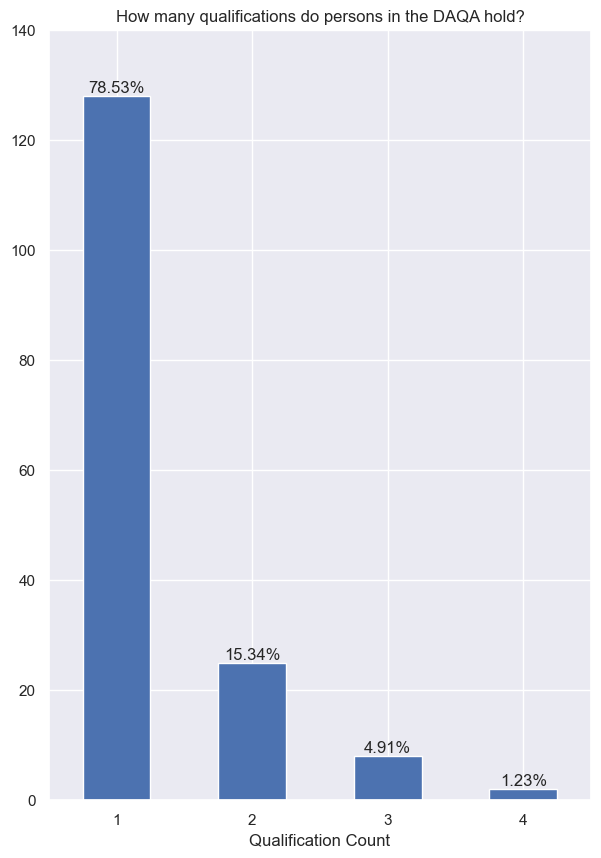

In [88]:
## bar chart of number of qualifications
df_persons_with_qual = pd.DataFrame(ee_df['display_name'].value_counts())\
                            .reset_index()\
                            .rename({'index':'Person',
                                     'display_name':'Frequency'}, axis=1)

df = pd.DataFrame(df_persons_with_qual['Frequency']\
        .value_counts())\
        .reset_index()\
        .rename({'index':'Qualification Count'}, axis=1)

labels = ((df['Frequency']/df_persons_with_qual.shape[0])*100)\
        .round(2).astype('str') + '%'

ax = df.plot.bar(x='Qualification Count', y='Frequency',rot=0)

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend and y-axis title
ax.legend().set_visible(False)
plt.ylabel(None)

plt.title('How many qualifications do persons in the DAQA hold?')
plt.ylim([0, 140])
plt.show()

# use to check people with multiple qualifications
# ee_df[(ee_df['display_name']\
#       .isin(df_persons_with_qual[df_persons_with_qual.Frequency > 2]['Person']\
#       .values))]\
#       .sort_values(['display_name','coverage_range.date_range.date_end'])

#### Education qualification types

Firstly, we plot the number of education records for each qualification type. We further aggregate the education qualifications into six broad categories. We find that most persons in DAQA have a Diploma (34% of records), followed by a Bachelor (29% of records). Next, we inspect the distribution of the location of the qualifications. Beyond Queensland, other locations with a high number of education records include New South Wales, Victoria, the United Kingdom and the United States. The last bar chart reveals the number of education records by education institution. We only show the top eight universities, with the University of Queensland being the most common. 

It should be noted that BCTC, QIT and QUT refer to the same institution, but have changed names over time. AA refers to the Architectural Association School of Architecture (based in the UK) and STC refers to the Sydney Technical College.

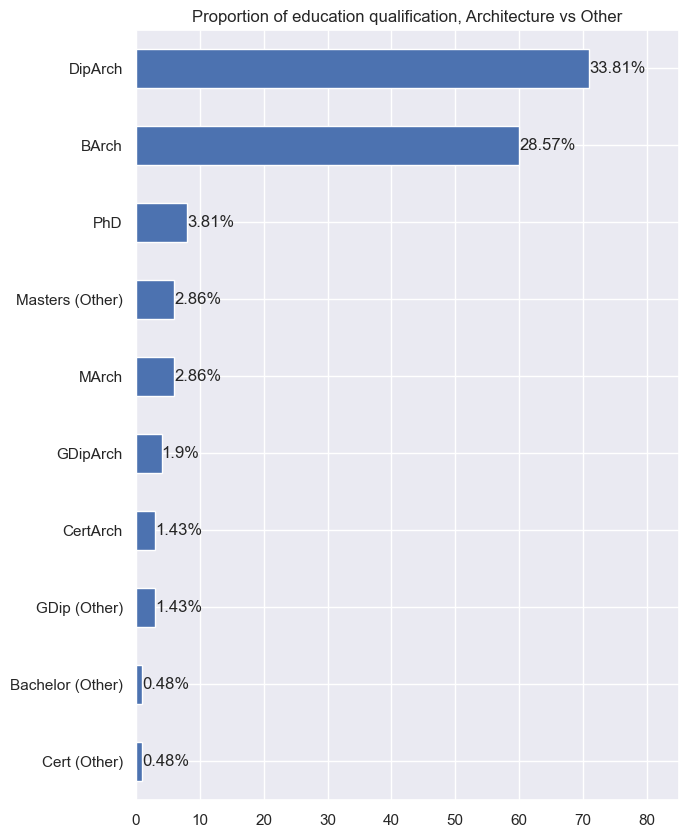

In [97]:
# bar chart of qualification
ee_freq = pd.DataFrame(ee_df_last['organization.qualification'].value_counts())

df = ee_freq\
    .reset_index()\
    .rename({'index':'Qualification',
             'organization.qualification':'Frequency'}, axis=1)\
    .sort_values('Frequency')

df = df[~df['Qualification'].isin(['Unknown'])]

# df['Colour'] = np.where(df['Place'].isin(['QLD','VIC','NSW','TAS']),'orange','steelblue')

labels = ((df['Frequency']/ee_df.shape[0])*100)\
        .round(2).astype('str') + '%'

ax = df.plot.barh(x='Qualification', y='Frequency',rot=0)

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend and y-axis title
ax.legend().set_visible(False)
plt.ylabel(None)
plt.title('Proportion of education qualification, Architecture vs Other')

plt.xlim([0, 85])
plt.show()

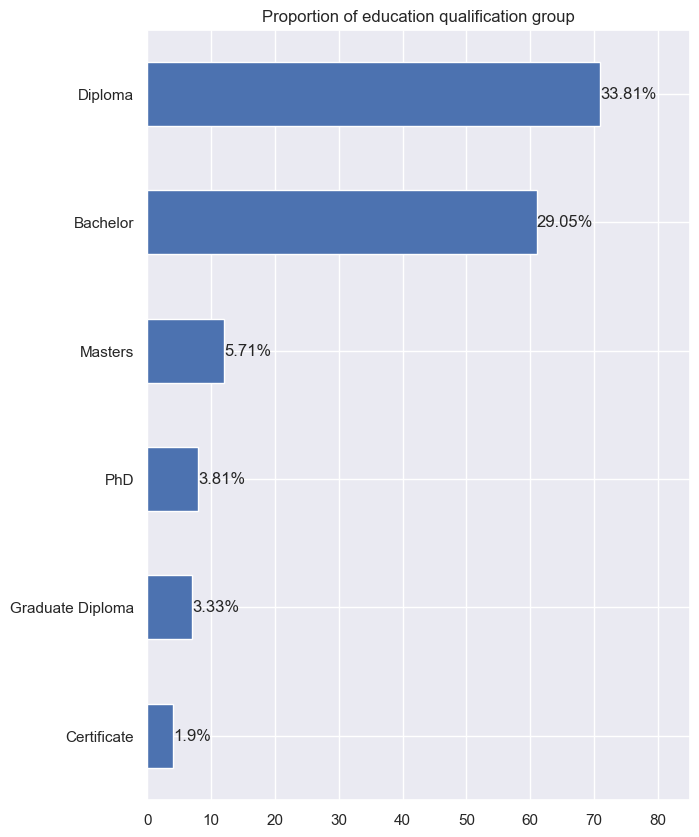

In [92]:
# keep last education record
ee_df_last = ee_df\
.sort_values(['coverage_range.date_range.date_end.year','display_name'])\
.drop_duplicates(subset='display_name', keep="last")

# bar chart of qualification type
ee_freq = pd.DataFrame(ee_df_last['organization.qualification2'].value_counts())

df = ee_freq\
    .reset_index()\
    .rename({'index':'Qualification Type',
             'organization.qualification2':'Frequency'}, axis=1)\
    .sort_values('Frequency')

df = df[~df['Qualification Type'].isin(['Unknown'])]

labels = ((df['Frequency']/ee_df.shape[0])*100)\
        .round(2).astype('str') + '%'

ax = df.plot.barh(x='Qualification Type', y='Frequency',rot=0)

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend and y-axis title
ax.legend().set_visible(False)
plt.ylabel(None)
plt.title('Proportion of education qualification group')

plt.xlim([0, 85])
plt.show()

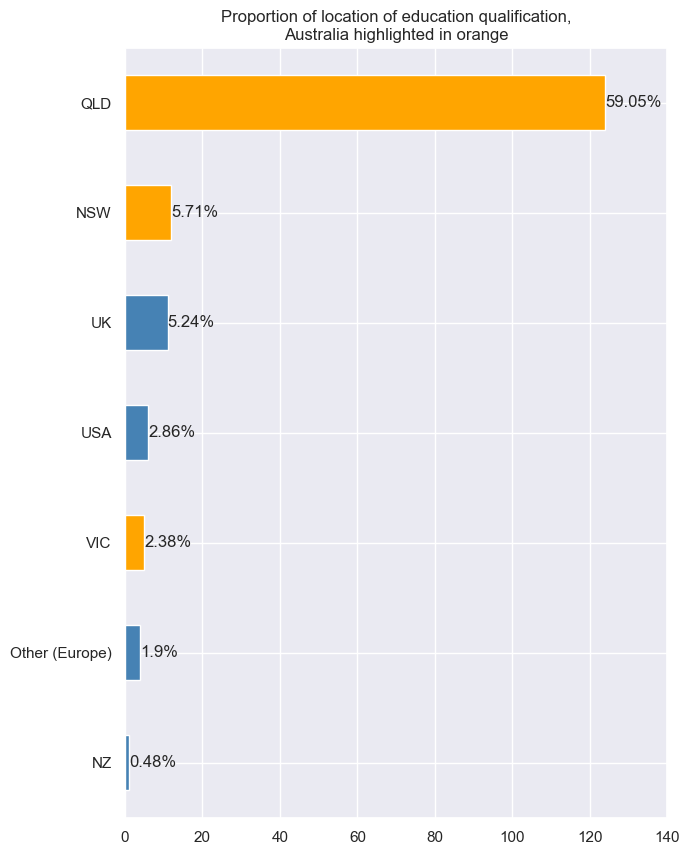

In [94]:
# bar chart of location of education institution
ee_freq = pd.DataFrame(ee_df_last['coverage_range.place'].value_counts())

df = ee_freq\
    .reset_index()\
    .rename({'index':'Place',
             'coverage_range.place':'Frequency'}, axis=1)\
    .sort_values('Frequency')

df['Colour'] = np.where(df['Place'].isin(['QLD','VIC','NSW','TAS']),'orange','steelblue')

labels = ((df['Frequency']/ee_df.shape[0])*100)\
        .round(2).astype('str') + '%'

ax = df.plot.barh(x='Place', y='Frequency', color=df['Colour'].values ,rot=0)

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend and y-axis title
ax.legend().set_visible(False)
plt.ylabel(None)
plt.title('Proportion of location of education qualification,\nAustralia highlighted in orange')

plt.xlim([0, 140])
plt.show()

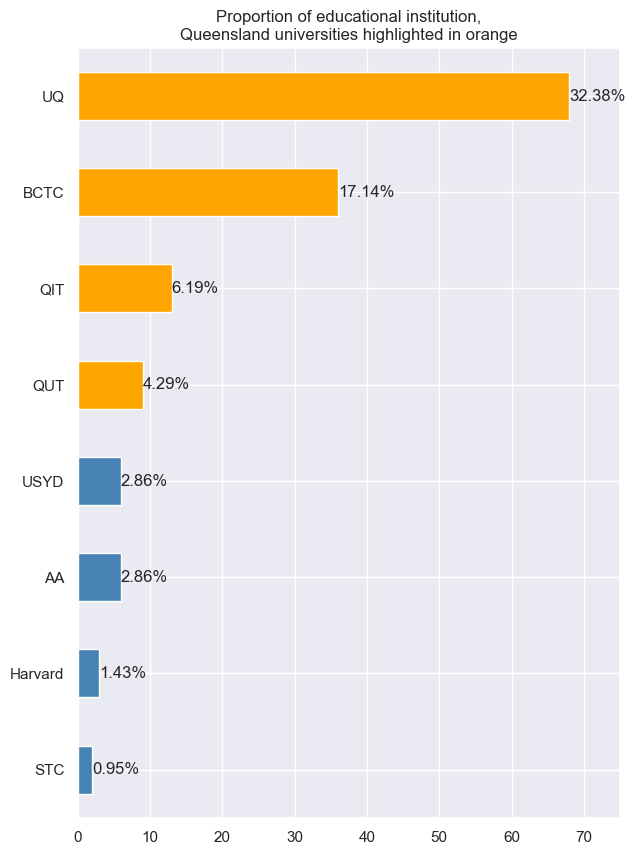

In [98]:
# bar chart of education institution
ee_freq = pd.DataFrame(ee_df_last['organization.name'].value_counts()).head(8)

df = ee_freq\
    .reset_index()\
    .rename({'index':'School Name',
             'organization.name':'Frequency'}, axis=1)\
    .sort_values('Frequency')

# df = df[~df['School Name'].isin(['Articled','NOT IN DAQA'])]

labels = ((df['Frequency']/ee_df.shape[0])*100)\
        .round(2).astype('str') + '%'

df['Colour'] = np.where(df['School Name']\
                        .isin(['UQ','BCTC','QIT','QUT']),
                        'orange','steelblue')

ax = df.plot.barh(x='School Name', y='Frequency', 
                  color=df['Colour'].values, rot=0)

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend
ax.legend().set_visible(False)
plt.ylabel(None)

plt.title('Proportion of educational institution,\nQueensland universities highlighted in orange')

plt.xlim([0, 75])
plt.show()

#### Education over time

We continue the analysis by visualising education records with respect to year. The histogram below highlights that most education records are from the 1960s and 1970s. We also plot the number of education records by year and education qualification.

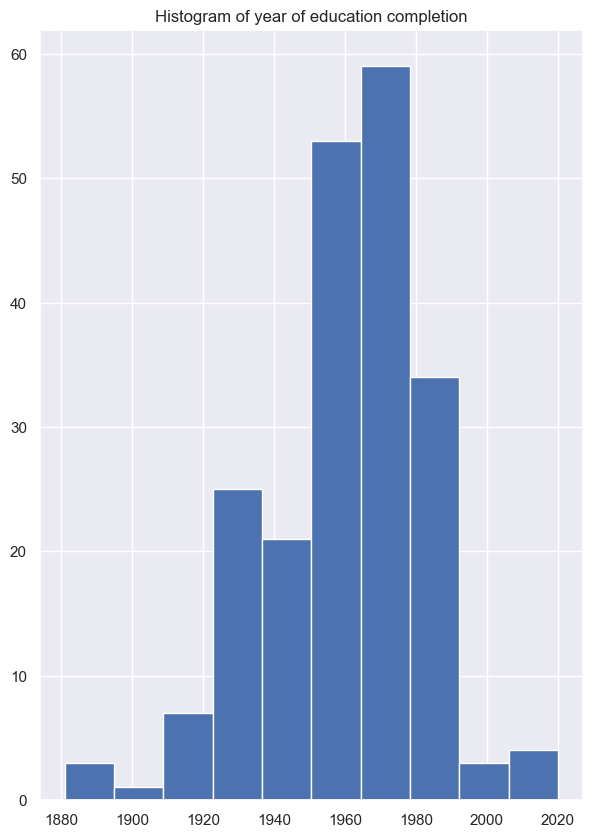

In [100]:
## Histogram of year of education completion
ee_df['coverage_range.date_range.date_end.year'] = ee_df['coverage_range.date_range.date_end.year']\
                                              .apply(lambda x: x[0:4])\
                                              .astype(int)
ee_df['coverage_range.date_range.date_end.year'].hist()

plt.title('Histogram of year of education completion')
plt.show()

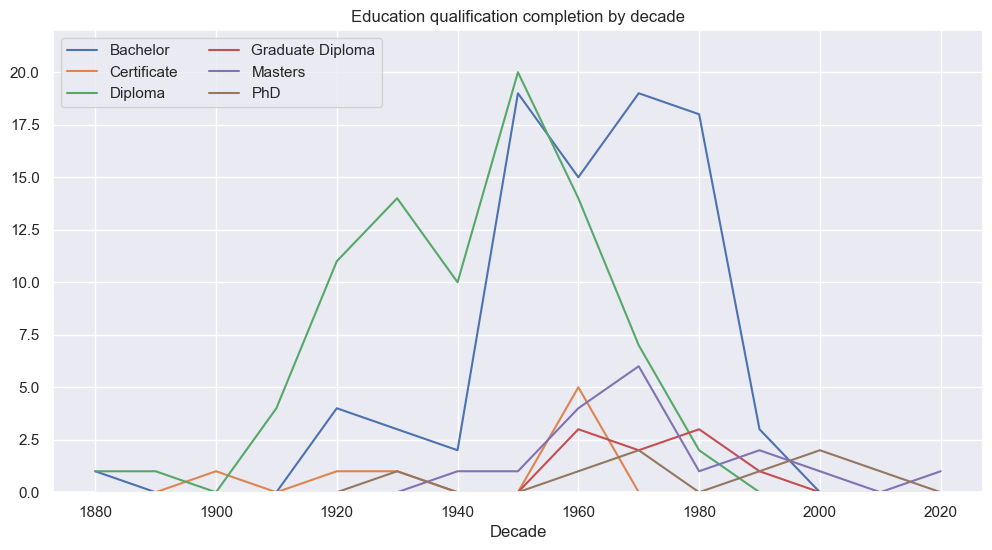

In [101]:
## line chart by decade of education completion
ee_df['date_end_decade'] = [ int(np.floor(int(year)/10) * 10) 
                            for year in np.array(ee_df['coverage_range.date_range.date_end.year'])]

ax = pd.crosstab(ee_df['date_end_decade'],
            ee_df['organization.qualification2'])\
.plot(rot=0, figsize=(12,6))

# adjust legend
ax.legend(loc="upper left", ncol=2)

plt.xlabel('Decade')
plt.ylim([0, 22])

plt.title('Education qualification completion by decade')
plt.show()

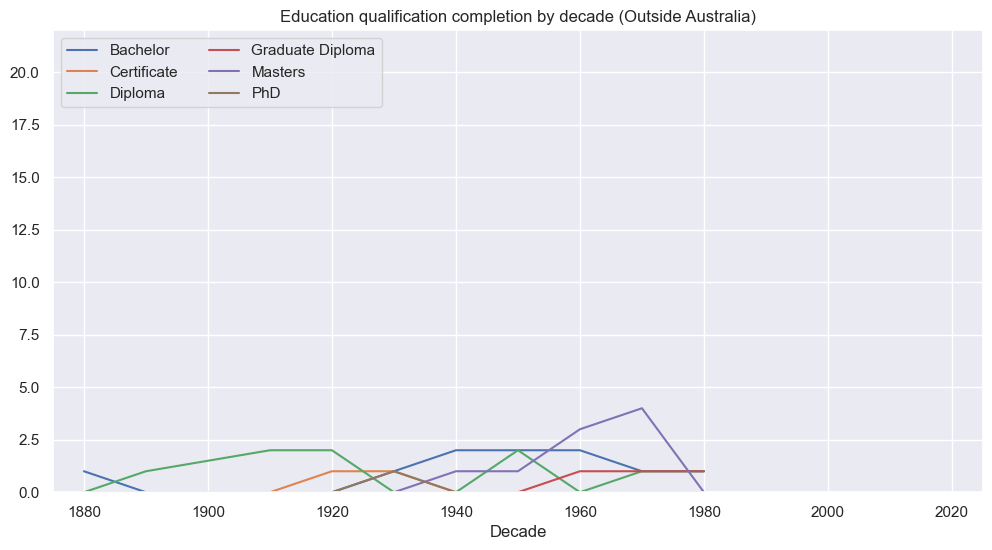

In [102]:
# line chart by decade of education completion (outside AUS)
ee_df_notqld = ee_df[~ee_df['coverage_range.place'].isin(['QLD','TAS','NSW','VIC'])]

ax = pd.crosstab(ee_df_notqld['date_end_decade'],
            ee_df_notqld['organization.qualification2'])\
.plot(rot=0, figsize=(12,6))

# adjust legend
ax.legend(loc="upper left", ncol=2)

plt.xlabel('Decade')
plt.xlim([1875, 2025])
plt.ylim([0, 22])

plt.title('Education qualification completion by decade (Outside Australia)')
plt.show()

#### Education over time (only Queensland)

Next we focus solely on education records from Queensland. A shift in the adoption of education qualification type is observed around the 1960s. This shift is particularly emphasised in the second visualisation where proportions of Bachelor and Diploma records are plotted. For further context, we also provide visualisations with respect to education institution and education qualification. 

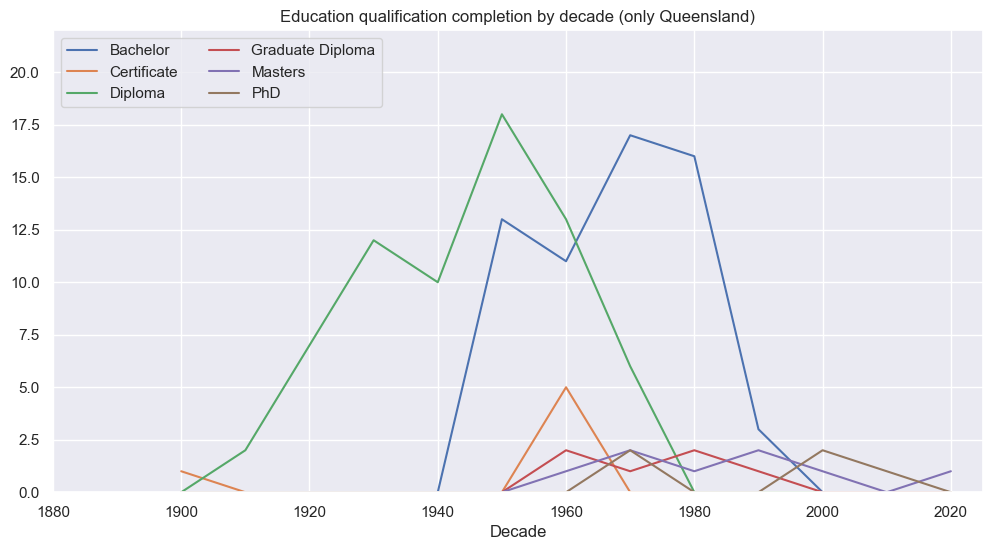

In [107]:
# line chart by decade of education completion (only queensland)
ee_df_qld = ee_df[ee_df['coverage_range.place'].isin(['QLD'])]

ax = pd.crosstab(ee_df_qld['date_end_decade'],
            ee_df_qld['organization.qualification2'])\
.plot(rot=0, figsize=(12,6))

# adjust legend
ax.legend(loc="upper left", ncol=2)

plt.xlabel('Decade')
plt.xlim([1880, 2025])
plt.ylim([0, 22])

plt.title('Education qualification completion by decade (only Queensland)')
plt.show()

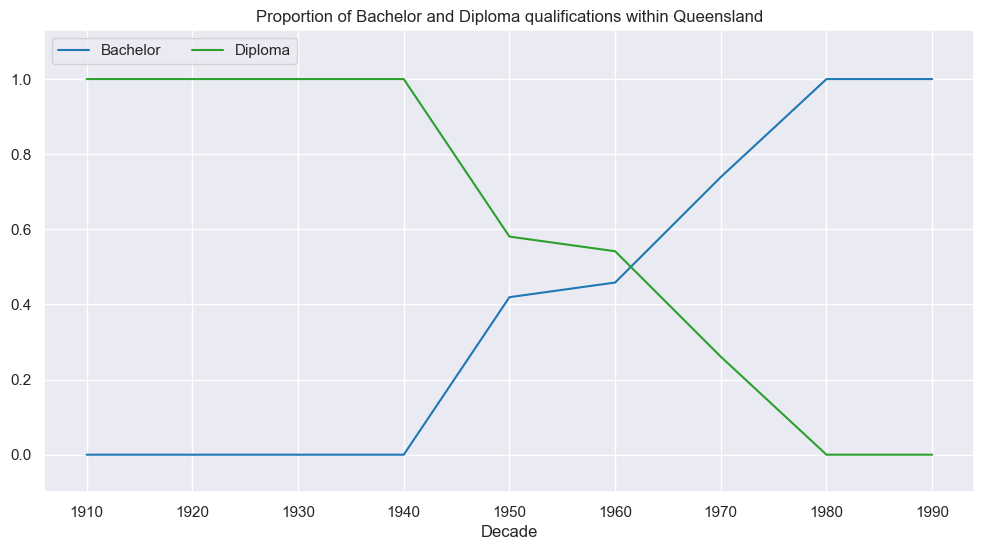

In [104]:
# bachelor/diploma proportion over decade (only queensland)
ee_df2 = ee_df[(ee_df['organization.qualification2'].isin(['Bachelor','Diploma'])) &
               (ee_df['coverage_range.place'].isin(['QLD']))]

ax = pd.crosstab(ee_df2['date_end_decade'],
            ee_df2['organization.qualification2'], normalize='index')\
.plot(rot=0, figsize=(12,6), color=['tab:blue','tab:green'])

# adjust legend
ax.legend(loc="upper left", ncol=2)

plt.xlabel('Decade')
plt.ylim([-0.1, 1.13])

plt.title('Proportion of Bachelor and Diploma qualifications within Queensland')
plt.show()

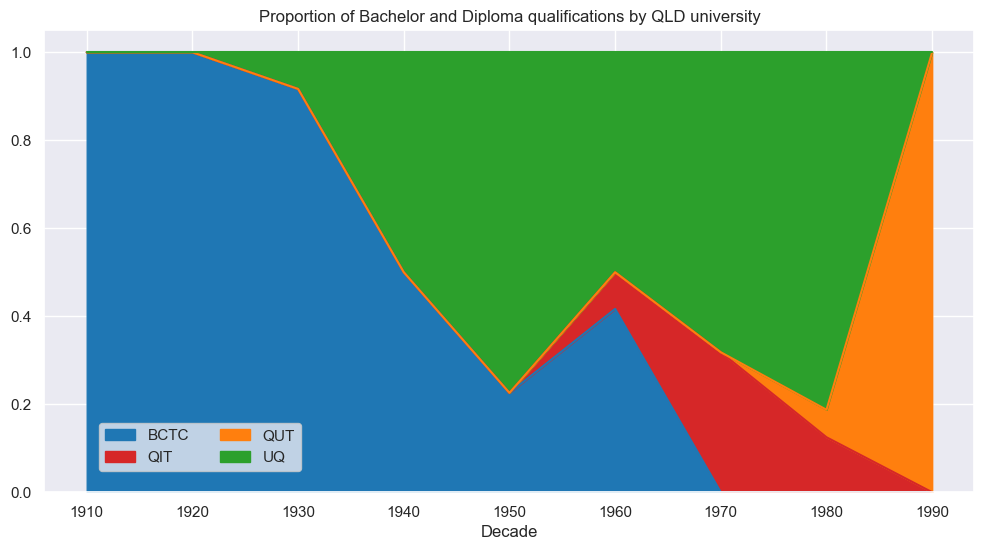

In [105]:
# bachelor/diploma over decade by qld institutions
ee_df2 = ee_df[(ee_df['organization.qualification2'].isin(['Bachelor','Diploma'])) &
               (ee_df['coverage_range.place'].isin(['QLD'])) &
               (~ee_df['organization.name'].isin(['Townsville TC']))]

ax = pd.crosstab(ee_df2['date_end_decade'],
                 ee_df2['organization.name'],normalize='index')\
.plot(kind='area',stacked=True,rot=0, figsize=(12,6), 
      color=['tab:blue','tab:red',
             'tab:orange','tab:green'])

# adjust legend
ax.legend(loc="lower left", ncol=2, bbox_to_anchor=(0.05, 0.03))

plt.xlabel('Decade')
plt.title('Proportion of Bachelor and Diploma qualifications by QLD university')
plt.show()

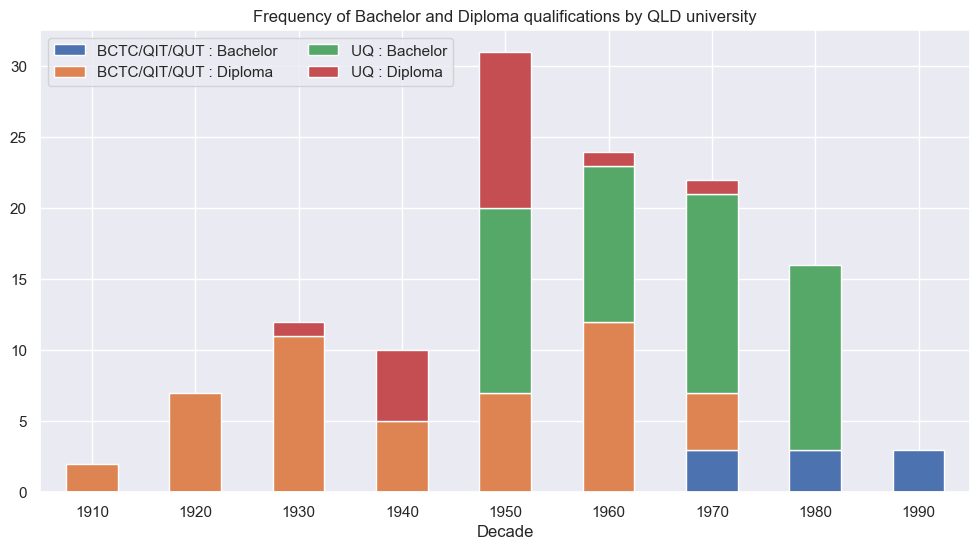

In [106]:
# bachelor/diploma over decade by qld institutions, summarised
ee_df2['main_qld_unis'] = np.where(ee_df2['organization.name'].isin(['BCTC','QUT','QIT']),
                                   'BCTC/QIT/QUT', ee_df2['organization.name'])
ee_df2['main_qld_unis'] = ee_df2['main_qld_unis'] + ' : ' + ee_df2['organization.qualification2']

ax = pd.crosstab(ee_df2['date_end_decade'],
                 ee_df2['main_qld_unis'])\
.plot(kind='bar',stacked=True,rot=0, figsize=(12,6))

# adjust legend
ax.legend(loc="upper left", ncol=2)

plt.xlabel('Decade')
plt.title('Frequency of Bachelor and Diploma qualifications by QLD university')
plt.show()

## DAQA Relationships

In [22]:
# # df_daqa_place.head(1).T
# print(f'There are {df_daqa_relationship.shape[0]} relationship records.')
# # df_daqa_relationship[['ori_id','title','_type','_class']].tail(5)

#### Persons with related work

In [23]:
# # clean data
# df_daqa_completions = df_daqa_relationship[~df_daqa_relationship['objectcompletion'].isnull()]
# df_daqa_completions_bypersons = df_daqa_completions[df_daqa_completions['relation_class'].isin(['Person_Relatedwork'])]
# df_daqa_completions_bypersons['predicate_term'] = df_daqa_completions_bypersons['predicate'].apply(lambda x: x['term'])
# df_daqa_completions_bypersons = df_daqa_completions_bypersons[df_daqa_completions_bypersons.predicate_term == 'WorkedOn']

In [24]:
# # inspect data
# ee_df = pd.DataFrame()
# for ii,ee in df_daqa_completions_bypersons.iterrows():
#     uniqueid = ee['subject_ori_url'] + '-' + ee['object_ori_url']
#     this_ee_subject = pd.json_normalize(ee['subject'])
#     this_ee_subject['uniqueid'] = uniqueid
#     this_ee_object = pd.json_normalize(ee['object'])
#     this_ee_object['uniqueid'] = uniqueid
#     this_ee = pd.merge(this_ee_subject,this_ee_object, on='uniqueid')
#     this_ee['typology'] = ee['typology']
#     this_ee['objectcompletion'] = ee['objectcompletion']
#     ee_df = ee_df.append(this_ee)

In [25]:
# # bar chart of related works frequency
# ee_freq = pd.DataFrame(ee_df['label_x'].value_counts())
# ee_df = pd.merge(ee_df,ee_freq.reset_index().rename({'index':'label_x','label_x':'Frequency'}, axis=1))
# topfour = ee_freq['label_x'].reset_index().head(4)
# topfour_arch = topfour['index'].values
# print(topfour.rename({'index':'Person','label_x':'Frequency'}, axis=1).T)

# df = pd.DataFrame(ee_freq\
#                  .reset_index()\
#                  .rename({'index':'Person',
#                          'label_x':'Frequency'}, axis=1))['Frequency']\
#                 .value_counts()

# df2 = pd.DataFrame(df\
#              .reset_index()\
#              .rename({'index':'RelatedWorksFrequency',
#                       'label_x':'Frequency'}, axis=1))

# df2['RelatedWorksFrequency2'] = np.where((df2['RelatedWorksFrequency'] < 2), df2['RelatedWorksFrequency'],
#                                 np.where((df2['RelatedWorksFrequency'] <= 3),'2-3',
#                                 np.where((df2['RelatedWorksFrequency'] <= 5),'4-5',
#                                 np.where((df2['RelatedWorksFrequency'] <= 10),'6-10',
#                                 np.where((df2['RelatedWorksFrequency'] <= 50),'11-50','+50')))))

# ee_df = pd.merge(ee_df,df2.reset_index()[['RelatedWorksFrequency','RelatedWorksFrequency2']]\
#                  .rename({'RelatedWorksFrequency':'Frequency'}, axis=1))

# df3 = df2.groupby('RelatedWorksFrequency2')['Frequency']\
#         .sum()\
#         .reset_index()\
#         .sort_values('Frequency', ascending=True)

# labels = (df3['Frequency']/df3['Frequency'].sum())\
#         .round(2).astype('str') + '%'

# ax = df3.reindex([0,2,5,4,3,1]).plot.barh(x='RelatedWorksFrequency2', y='Frequency',rot=0)

# # add bar labels
# [ax.bar_label(container, labels=labels) 
#  for container in ax.containers]

# # remove legend and y-axis title
# ax.legend().set_visible(False)
# plt.ylabel(None)

# plt.xlim([0, 75])
# plt.title('How many (completed) works are related to a person in the DAQA?')
# plt.show()

In [26]:
# #check for pareto principle
# samples = ee_df['label_x'].value_counts()
# output = np.array([pareto.pdf(x=samples, b=1, loc=0, scale=1)])
# plt.plot(samples, output.T, label='alpha {0}' .format(1))
    
# plt.xlabel('samples', fontsize=15)
# plt.ylabel('PDF', fontsize=15)
# plt.title('Pareto-like distribution, \n70% of buildings are worked on by 30% of architects in DAQA.', fontsize=15)
# # plt.grid(b=True, color='grey', alpha=0.3, linestyle='-.', linewidth=2)
# # plt.legend(loc='best')
# plt.show()

In [27]:
# # categorical associations - typology and completed projects
# ax = pd.crosstab(ee_df['typology'], 
#             ee_df['RelatedWorksFrequency2'], normalize='index')\
# .plot(kind='barh', rot=0, stacked=True, figsize=(8,10))

# ax.legend(loc="upper right", ncol=6, bbox_to_anchor=(0.96, 1.08))
# plt.ylabel(None)

# plt.title('Typology by number of related (completed) works by person\n\n\n\n')
# plt.show()

In [28]:
# # Median number of completions for an architect by typology
# ax=ee_df.groupby('typology')['Frequency'].median().reset_index().sort_values('Frequency',ascending=True)\
# .plot('typology','Frequency',kind='barh',rot=0, figsize=(8,8))

# # remove legend and y-axis title
# ax.legend().set_visible(False)
# plt.ylabel(None)

# plt.title('Median number of (completed) works for an architect by typology')
# plt.show()

In [29]:
# over 50/under 50
# ee_df['RelatedWorksFrequency3'] = np.where(ee_df['RelatedWorksFrequency2'] == '+50', 'Over 50', 'Under 50')
# ax = pd.crosstab(ee_df['typology'], 
#             ee_df['RelatedWorksFrequency3'], normalize='index')\
# .plot(kind='barh', rot=0, stacked=True)

# ax.legend(loc="upper right", ncol=1, bbox_to_anchor=(1.22, 1.02))
# plt.show()

In [30]:
# # total completions over time
# # ee_df["objectcompletion_asdt"] = ee_df["objectcompletion"].apply(func)
# ee_df["objectcompletion_asdt"] = ee_df["objectcompletion"].apply(lambda x: x[0:4])
# ee_df["objectcompletion_asdt"] = ee_df["objectcompletion_asdt"]\
# .apply(lambda x: datetime.strptime(x, '%Y'))

# total_completions=ee_df['objectcompletion_asdt']\
# .value_counts()\
# .reset_index()\
# .rename({'index':'Completion Date','objectcompletion_asdt':'Frequency'}, axis=1)\
# .sort_values('Completion Date')

# sns.set(rc={'figure.figsize':(12,6)})
# sns.lineplot(data=total_completions, x="Completion Date", y="Frequency")

# # remove legend
# plt.ylabel(None)

# plt.title('Total number of (completed) works by year')
# plt.show()

In [31]:
# # total four (individually) vs rest over time
# sns.set(rc={'figure.figsize':(12,6)})

# rest_completions = ee_df[~ee_df['label_x']\
#                         .isin(topfour_arch)]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# rest_completions[''] = 'Rest'

# lp_completions = ee_df[ee_df['label_x']\
#                         .isin(['Lange Powell'])]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# lp_completions[''] = 'Lange Powell'

# rg_completions = ee_df[ee_df['label_x']\
#                         .isin(['Robin Gibson'])]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# rg_completions[''] = 'Robin Gibson'

# jd_completions = ee_df[ee_df['label_x']\
#                         .isin(['John Dalton'])]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# jd_completions[''] = 'John Dalton'

# gb_completions = ee_df[ee_df['label_x']\
#                         .isin(['Graham Bligh'])]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# gb_completions[''] = 'Graham Bligh'

# color_dict = {'Lange Powell': to_rgba('tab:red', 0.3),
#               'Robin Gibson': to_rgba('tab:purple', 0.3),
#               'John Dalton': to_rgba('tab:orange', 0.3),
#               'Graham Bligh': to_rgba('tab:brown', 0.3),
#               'Rest': to_rgba('tab:blue', 0.1)}

# allcompletions = rest_completions.append(lp_completions)
# allcompletions = allcompletions.append(rg_completions)
# allcompletions = allcompletions.append(jd_completions)
# allcompletions = allcompletions.append(gb_completions)
# # allcompletions["Completion Date"] = allcompletions["Completion Date"].apply(func)


# ax = sns.displot(allcompletions, x='Completion Date', kind='hist',bins=25,height=6,aspect=1.75,
#             hue="", fill=True, palette = color_dict, element="poly", multiple="stack")

# sns.move_legend(ax, "upper center", ncol=5, bbox_to_anchor=(0.45, 1.03))
# # plt.ylim([0, 50])
# plt.title('Total number of (completed) works by year, most active architects vs. rest\n\n')
# plt.show()

#### Organisations with related works

In [32]:
# # inspect data
# df_daqa_completions_byorg = df_daqa_completions[df_daqa_completions['relation_class'].isin(['Organization_Relatedwork'])]

# ee_df = pd.DataFrame()
# for ii,ee in df_daqa_completions_byorg.iterrows():
#     uniqueid = ee['subject_ori_url'] + '-' + ee['object_ori_url']
#     this_ee_subject = pd.json_normalize(ee['subject'])
#     this_ee_subject['uniqueid'] = uniqueid
#     this_ee_object = pd.json_normalize(ee['object'])
#     this_ee_object['uniqueid'] = uniqueid
#     this_ee = pd.merge(this_ee_subject,this_ee_object, on='uniqueid')
#     this_ee['typology'] = ee['typology']
#     this_ee['objectcompletion'] = ee['objectcompletion']
#     ee_df = ee_df.append(this_ee)

In [33]:
# # bar chart of related works frequency
# ee_freq = pd.DataFrame(ee_df['label_x'].value_counts())
# ee_df = pd.merge(ee_df,ee_freq.reset_index().rename({'index':'label_x','label_x':'Frequency'}, axis=1))
# topfour = ee_freq['label_x'].reset_index().head(5)
# topfour_arch = topfour['index'].values
# print(topfour.rename({'index':'Person','label_x':'Frequency'}, axis=1).T)

# df = pd.DataFrame(ee_freq\
#                  .reset_index()\
#                  .rename({'index':'Person',
#                          'label_x':'Frequency'}, axis=1))['Frequency']\
#                 .value_counts()

# df2 = pd.DataFrame(df\
#              .reset_index()\
#              .rename({'index':'RelatedWorksFrequency',
#                       'label_x':'Frequency'}, axis=1))

# df2['RelatedWorksFrequency2'] = np.where((df2['RelatedWorksFrequency'] < 2), df2['RelatedWorksFrequency'],
#                                 np.where((df2['RelatedWorksFrequency'] <= 3),'2-3',
#                                 np.where((df2['RelatedWorksFrequency'] <= 5),'4-5',
#                                 np.where((df2['RelatedWorksFrequency'] <= 10),'6-10',
#                                 np.where((df2['RelatedWorksFrequency'] <= 30),'11-29','+30')))))

# ee_df = pd.merge(ee_df,df2.reset_index()[['RelatedWorksFrequency','RelatedWorksFrequency2']]\
#                  .rename({'RelatedWorksFrequency':'Frequency'}, axis=1))

# df3 = df2.groupby('RelatedWorksFrequency2')['Frequency']\
#         .sum()\
#         .reset_index()\
#         .sort_values('Frequency', ascending=True)

# labels = (df3['Frequency']/df3['Frequency'].sum())\
#         .round(2).astype('str') + '%'

# ax = df3.reindex([0,2,5,4,3,1]).plot.barh(x='RelatedWorksFrequency2', y='Frequency',rot=0)

# # add bar labels
# [ax.bar_label(container, labels=labels) 
#  for container in ax.containers]

# # remove legend and y-axis title
# ax.legend().set_visible(False)
# plt.ylabel(None)

# plt.xlim([0, 75])
# plt.title('How many (completed) works are related to a firm in the DAQA?')
# plt.show()

In [34]:
# # categorical associations - typology and completed projects
# ax = pd.crosstab(ee_df['typology'], 
#             ee_df['RelatedWorksFrequency2'], normalize='index')\
# .plot(kind='barh', rot=0, stacked=True, figsize=(8,10))

# ax.legend(loc="upper right", ncol=6, bbox_to_anchor=(0.96, 1.08))
# plt.ylabel(None)
# plt.title('Typology by number of related (completed) works by firm\n\n\n\n')
# plt.show()

In [35]:
# #check for pareto principle
# samples = ee_df['label_x'].value_counts()
# output = np.array([pareto.pdf(x=samples, b=1, loc=0, scale=1)])
# plt.plot(samples, output.T, label='alpha {0}' .format(1))
    
# plt.xlabel('samples', fontsize=15)
# plt.ylabel('PDF', fontsize=15)
# plt.title('Pareto-like distribution, \n70% of buildings are worked on by 30% of firms in DAQA.', fontsize=15)
# # plt.grid(b=True, color='grey', alpha=0.3, linestyle='-.', linewidth=2)
# # plt.legend(loc='best')
# plt.show()

In [36]:
# # Median number of completions for an architect by typology
# ax=ee_df.groupby('typology')['Frequency'].median().reset_index().sort_values('Frequency',ascending=True)\
# .plot('typology','Frequency',kind='barh',rot=0, figsize=(8,8))

# # remove legend and y-axis title
# ax.legend().set_visible(False)
# plt.ylabel(None)
# plt.title('Median number of (completed) works for a firm by typology')
# plt.show()

In [37]:
# over 50/under 50
# ee_df['RelatedWorksFrequency3'] = np.where(ee_df['RelatedWorksFrequency2'] == '+50', 'Over 50', 'Under 50')
# ax = pd.crosstab(ee_df['typology'], 
#             ee_df['RelatedWorksFrequency3'], normalize='index')\
# .plot(kind='barh', rot=0, stacked=True)

# ax.legend(loc="upper right", ncol=1, bbox_to_anchor=(1.22, 1.02))
# plt.show()

In [38]:
# # total completions over time
# ee_df["objectcompletion_asdt"] = ee_df["objectcompletion"].apply(func)

# total_completions=ee_df['objectcompletion_asdt']\
# .value_counts()\
# .reset_index()\
# .rename({'index':'Completion Date','objectcompletion_asdt':'Frequency'}, axis=1)\
# .sort_values('Completion Date')

# sns.set(rc={'figure.figsize':(12,6)})
# sns.lineplot(data=total_completions, x="Completion Date", y="Frequency")

# # remove legend
# plt.ylabel(None)
# plt.show()

In [39]:
# # total five (individually) vs rest over time
# sns.set(rc={'figure.figsize':(12,6)})

# # ee_df["objectcompletion_asdt"] = ee_df["objectcompletion"].apply(func)

# ee_df["objectcompletion_asdt"] = ee_df["objectcompletion"].apply(lambda x: x[0:4])
# ee_df["objectcompletion_asdt"] = ee_df["objectcompletion_asdt"]\
# .apply(lambda x: datetime.strptime(x, '%Y'))

# rest_completions = ee_df[~ee_df['label_x']\
#                         .isin(topfour_arch)]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# rest_completions[''] = 'Rest'

# bjb_completions = ee_df[ee_df['label_x']\
#                         .isin(['Bligh Jessup Bretnall & Partners'])]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# bjb_completions[''] = 'Bligh Jessup Bretnall & Partners'

# jd_completions = ee_df[ee_df['label_x']\
#                         .isin(['John Dalton Architect & Associates'])]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# jd_completions[''] = 'John Dalton Architect & Associates'

# rg_completions = ee_df[ee_df['label_x']\
#                         .isin(['Robin Gibson & Partners'])]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# rg_completions[''] = 'Robin Gibson & Partners'

# kla_completions = ee_df[ee_df['label_x']\
#                         .isin(['Karl Langer Architect'])]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# kla_completions[''] = 'Karl Langer Architect'

# hd_completions = ee_df[ee_df['label_x']\
#                         .isin(['Hall & Dods'])]['objectcompletion_asdt']\
#                         .value_counts()\
#                         .reset_index()\
#                         .rename({'index':'Completion Date',
#                                  'objectcompletion_asdt':'Frequency'}, axis=1)\
#                         .sort_values('Completion Date')
# hd_completions[''] = 'Hall & Dods'

# color_dict = {'Bligh Jessup Bretnall & Partners': to_rgba('tab:red', 0.3),
#               'Robin Gibson & Partners': to_rgba('tab:purple', 0.3),
#               'John Dalton Architect & Associates': to_rgba('tab:orange', 0.3),
#               'Karl Langer Architect': to_rgba('tab:brown', 0.3),
#               'Hall & Dods': to_rgba('tab:olive', 0.3),
#               'Rest': to_rgba('tab:blue', 0.1)}

# allcompletions = rest_completions.append(bjb_completions)
# allcompletions = allcompletions.append(jd_completions)
# allcompletions = allcompletions.append(rg_completions)
# allcompletions = allcompletions.append(kla_completions)
# allcompletions = allcompletions.append(hd_completions)

# ax = sns.displot(allcompletions, x='Completion Date', kind='hist',bins=25,height=6,aspect=1.75,
#             hue="", fill=True, palette = color_dict, element="poly", multiple="stack")

# sns.move_legend(ax, "upper center", ncol=3, bbox_to_anchor=(0.4, 1.08))
# plt.title('Total number of (completed) works by year, most active firms vs. rest\n\n\n\n')
# plt.show()

#### Person and organisation relationships

In [40]:
# daqa_person_orgs = []

# for idx, row in df_daqa_dict['person'].iterrows():
#     try: daqa_person_orgs.append(pd.json_normalize(json.loads(row['related_organizations'])))
#     except: continue

# # turn list to dataframe
# daqa_person_orgs = pd.concat(daqa_person_orgs)
# print(f'There are {daqa_person_orgs.shape[0]} person-organisation relation records.')

In [41]:
# daqa_person_orgs = []

# for idx, row in df_daqa_dict['person'].iterrows():
#     try: daqa_person_orgs.append(pd.json_normalize(json.loads(row['related_organizations'])))
#     except: continue

# # turn list to dataframe
# daqa_person_orgs = pd.concat(daqa_person_orgs)
# print(f'There are {daqa_person_orgs.shape[0]} person-organisation relation records.')

# # bar chart of predicate type for person/org relationships
# df = pd.DataFrame(
#         daqa_person_orgs['predicate.term']
#         .value_counts()\
#         .reset_index())\
#         .rename({'index':'Predicate',
#                  'predicate.term':'Frequency'}, axis=1)\
#         .sort_values('Frequency')

# # ee_freq = pd.DataFrame(ee_df_last['school.qualification2'].value_counts())
# # print(ee_freq.T,'\n')

# labels = ((df['Frequency']/daqa_person_orgs.shape[0])*100)\
#         .round(2).astype('str') + '%'

# sns.set(rc={'figure.figsize':(7,10)})
# ax = df.plot.barh(x='Predicate', y='Frequency',rot=0)

# # add bar labels
# [ax.bar_label(container, labels=labels) 
#  for container in ax.containers]

# # remove legend and y-axis title
# ax.legend().set_visible(False)
# plt.ylabel(None)

# plt.xlim([0, 1400])
# plt.title('Proportion of person-organisation relationship types')
# plt.show()

In [42]:
# # Employment summary
# sns.set(rc={'figure.figsize':(12,8)})
# daqa_person_orgs['yeardiff'] = daqa_person_orgs['untilyear'] - daqa_person_orgs['fromyear']
# daqa_person_orgs_pos = daqa_person_orgs[~daqa_person_orgs['yeardiff'].isnull()]
# daqa_person_orgs_pos = daqa_person_orgs_pos[daqa_person_orgs_pos['yeardiff'] >= 0]

# print(f'There are {daqa_person_orgs_pos.shape[0]} person-organisation relation records with date data.\n')
# print(pd.DataFrame(daqa_person_orgs_pos['yeardiff'].describe()[['mean','std','min','25%','50%','75%','max']]).T)
# daqa_person_orgs_pos['yeardiff'].hist(bins=15)

# plt.title('Histogram of person-organisation employment duration')
# plt.show()

## DAQA Organisations

There are 967 organisation records in DAQA. The bar chart below shows the proportion of organisations by type, with the majority being architectural firms. We also plot the number of types of person-organisation relationships. We find that three-quarters of these relationships are employment-related.

            "firm"  "education"  "organisation"  "government"
_class_ori     907           39              15             6 



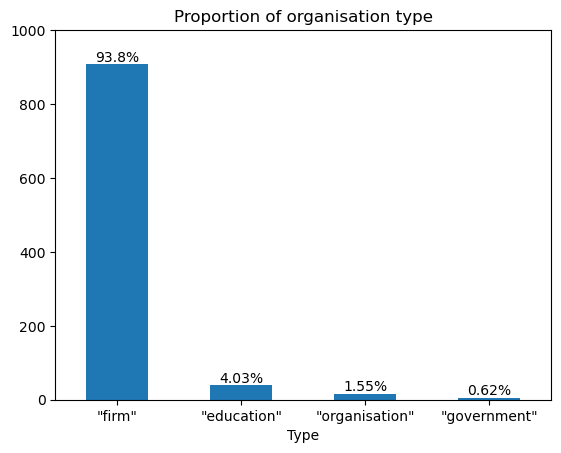

In [43]:
# bar chart of organisation type
type_freq = pd.DataFrame(df_daqa_dict['organization']['_class_ori'].value_counts())
print(type_freq.T,'\n')

df = type_freq\
    .reset_index()\
    .rename({'index':'Type',
             '_class_ori':'Frequency'}, axis=1)
             
labels = ((df['Frequency']/df_daqa_dict['organization'].shape[0])*100)\
        .round(2).astype('str') + '%'

ax = df.plot.bar(x='Type', y='Frequency', rot=0)

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend
ax.legend().set_visible(False)

# increase y-axuis limit
ax.set_ylim(0, 1000)

plt.title('Proportion of organisation type')
plt.show()

There are 1575 person-organisation relation records.


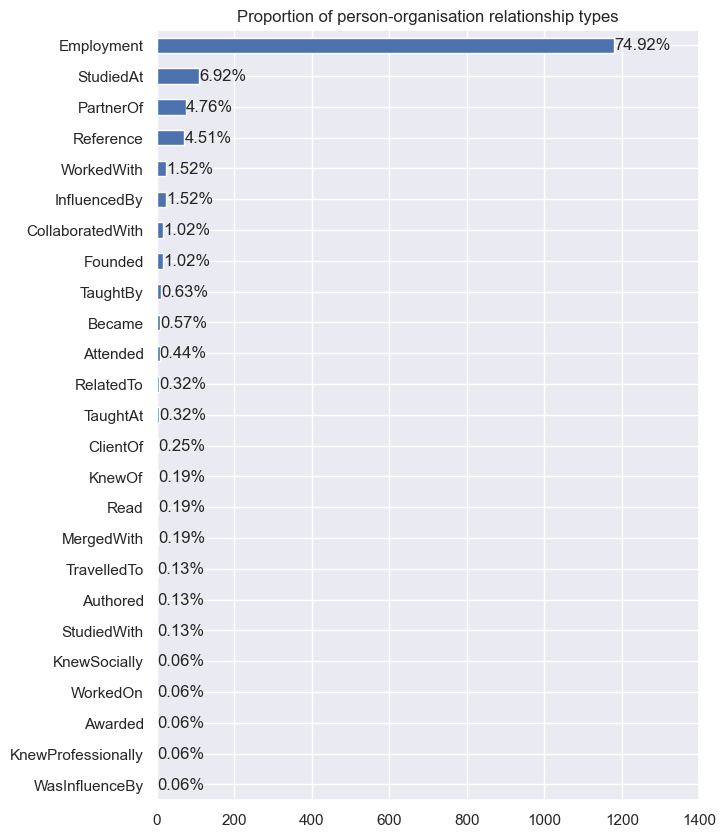

In [44]:
daqa_person_orgs = []

for idx, row in df_daqa_dict['person'].iterrows():
    try: daqa_person_orgs.append(pd.json_normalize(json.loads(row['related_organizations'])))
    except: continue

# turn list to dataframe
daqa_person_orgs = pd.concat(daqa_person_orgs)
print(f'There are {daqa_person_orgs.shape[0]} person-organisation relation records.')

# bar chart of predicate type for person/org relationships
df = pd.DataFrame(
        daqa_person_orgs['predicate.term']
        .value_counts()\
        .reset_index())\
        .rename({'index':'Predicate',
                 'predicate.term':'Frequency'}, axis=1)\
        .sort_values('Frequency')

# ee_freq = pd.DataFrame(ee_df_last['school.qualification2'].value_counts())
# print(ee_freq.T,'\n')

labels = ((df['Frequency']/daqa_person_orgs.shape[0])*100)\
        .round(2).astype('str') + '%'

sns.set(rc={'figure.figsize':(7,10)})
ax = df.plot.barh(x='Predicate', y='Frequency',rot=0)

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend and y-axis title
ax.legend().set_visible(False)
plt.ylabel(None)

plt.xlim([0, 1400])
plt.title('Proportion of person-organisation relationship types')
plt.show()